In [1]:
# The C2QA pacakge is currently not published to PyPI. 
# To use the package locally, add the C2QA repository's root folder to the path prior to importing c2qa.
import os
import sys
module_path = os.path.abspath(os.path.join("../.."))
if module_path not in sys.path:
    sys.path.append(module_path)

# Cheat to get MS Visual Studio Code Jupyter server to recognize Python venv
module_path = os.path.abspath(os.path.join("../../venv/Lib/site-packages"))
if module_path not in sys.path:
    sys.path.append(module_path)

# Implement Jaynes-Cummings model simulation

In [2]:
import c2qa
import numpy
import qiskit
import scipy.sparse.linalg
from scipy.sparse import kron

num_qumodes = 1
num_qubits_per_qumode = 4
num_qubits = 2
total_qubits = num_qumodes * num_qubits_per_qumode + num_qubits

## Define functions to calculate Hamiltonian and simulate circuit in loop

In [3]:
def simulate_jaynes_cummings(c1, c2, d1, d2, t, psi = None):
    qmr = c2qa.QumodeRegister(num_qumodes=num_qumodes, num_qubits_per_qumode=num_qubits_per_qumode)
    qr = qiskit.QuantumRegister(size=num_qubits)
    cr = qiskit.ClassicalRegister(size=1)
    circuit = c2qa.CVCircuit(qmr, qr, cr)

    if psi:
        circuit.initialize(psi)

    circuit.rz(-1 * c1 * t, qr[0])
    circuit.rz(-1 * c2 * t, qr[1])
    circuit.cx(qr[0], qr[1])
    circuit.h(qr[0])
    circuit.cv_cnd_d(d1, d1, qr[0], qmr[0], inverse=True)
    circuit.cx(qr[1], qr[0])
    circuit.cv_cnd_d(d1, d1, qr[0], qmr[0])
    circuit.cx(qr[1], qr[0])
    circuit.cv_cnd_d(d2, d2, qr[0], qmr[0], inverse=True)
    circuit.cx(qr[1], qr[0])
    circuit.cv_cnd_d(d2, d2, qr[0], qmr[0])
    circuit.cx(qr[1], qr[0])
    circuit.h(qr[0])
    circuit.cx(qr[0], qr[1])

    state, _ = c2qa.util.simulate(circuit)
    return circuit, state

In [4]:
def calculate_hamiltonian(c1, c2, d, circuit: c2qa.CVCircuit):
    X = scipy.sparse.csr_matrix([[0, 1], [1, 0]])      # Pauli X
    Y = scipy.sparse.csr_matrix([[0, -1j], [-1j, 0]])  # Pauli Y
    Z = scipy.sparse.csr_matrix([[1, 0], [0, -1]])     # Pauli Z

    b = circuit.ops.a
    b_dag = circuit.ops.a_dag

    # Hamiltonian
    #   H = (c1 * a_dag1 * a1) + (c2 * a_dag2 * a2) + d( (a_dag1 * a2 * b) + (a_dag2 * a1 * b_dag) )
    #     c1, c2, d -- constants supplied by user
    #     a_dag1, a1, a_dag2, a2 -- fermionic creation & annihilation operators
    #     b_dag, b -- bosonic creation & annihilation operators

    # Jordan-Wigner Transformation
    #   H = (-1 * c1 / 2 * Z) - (c2 / 2 * Z) + d * ( ((kron(X, X) + kron(Y, Y)) / 4 * (b + b_dag)) + (1j * (kron(X, Y) - kron(Y, X)) / 4 * (b - b_dag)) )
    eye_f = scipy.sparse.csr_matrix([[1, 0], [ 0, 1]])
    eye_b = circuit.ops.eye
    eye_tensor = kron(eye_f, eye_b)

    term1 = kron((-1 * c1 / 2 * Z), eye_tensor)
    term2 = kron((c2 / 2 * Z), eye_tensor)

    xx = kron(X, X)
    yy = kron(Y, Y)
    xx_yy = xx + yy
    term3 = kron((xx_yy / 4), (b + b_dag))

    xy = kron(X, Y)
    yx = kron(Y, X)
    xy_yx = xy - yx
    term4 = kron((1j * (xy_yx / 4)), (b - b_dag))

    tmp1 = term1 - term2
    tmp2 = d * (term3 + term4)

    h = tmp1 + tmp2
    return h


## Loop while reducing time t

In [5]:
# Parameter constants
c1 = 1
c2 = 1
d = 1

results = []

for i in range (100, 0, -10):
    # i = 10
    t = i / 1000

    d1 = (-1j * d * t) / 2
    d2 = (d * t) / 2

    psi = qiskit.quantum_info.random_statevector(2 ** total_qubits)
    psi_matrix = qiskit.quantum_info.DensityMatrix(psi).data

    circuit, state = simulate_jaynes_cummings(c1, c2, d1, d2, t, psi=psi)
    state_matrix = qiskit.quantum_info.DensityMatrix(state).data
    h = calculate_hamiltonian(c1, c2, d, circuit)

    h_psi = h * psi

    state_psi = (-1j / t) * (numpy.eye(state_matrix.shape[0], state_matrix.shape[1]) - state_matrix) * psi_matrix

    result = h_psi - state_psi
    results.append(result)
    print("****************")
    print(f"Result at t={t}")
    print(result.shape)
    print(result)


c:\Users\stav405\git\c2qa-qiskit\venv\lib\site-packages\scipy\sparse\linalg\dsolve\linsolve.py:318: SparseEfficiencyWarning: splu requires CSC matrix format
  warn('splu requires CSC matrix format', SparseEfficiencyWarning)
c:\Users\stav405\git\c2qa-qiskit\venv\lib\site-packages\scipy\sparse\linalg\dsolve\linsolve.py:215: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  warn('spsolve is more efficient when sparse b '
c:\Users\stav405\git\c2qa-qiskit\venv\lib\site-packages\qiskit\extensions\quantum_initializer\squ.py:143: RuntimeWarning: invalid value encountered in arccos
  beta = 2 * np.arccos(np.abs(u00))


****************
Result at t=0.1
(64, 64)
[[-0.20197807+0.37993571j -0.14794743-0.09065648j -0.08111199+0.20123732j
  ...  0.01542951+0.05288584j  0.07422086+0.14370209j
  -0.09520585+0.06390234j]
 [-0.19390793-0.01823423j -0.13987729+0.17873164j -0.09806205+0.2048265j
  ...  0.01616409+0.05446529j  0.08341927+0.13788289j
  -0.09821288+0.06281845j]
 [-0.21991281-0.00656427j -0.14086196-0.07539734j -0.09904673+0.64384512j
  ...  0.01279243+0.05534447j  0.09157233+0.15807154j
  -0.09500151+0.05728955j]
 ...
 [-0.2023021 -0.01593314j -0.14093589-0.08677595j -0.09673367+0.19432707j
  ...  0.01510549+0.08689661j  0.08493208+0.14435708j
  -0.09698447+0.06130086j]
 [-0.18978793-0.0144715j  -0.13688555-0.09271295j -0.10420806+0.20769955j
  ...  0.01658441+0.05500248j  0.086411  +0.41735313j
  -0.0994559 +0.06267192j]
 [-0.20406763-0.01109811j -0.13895982-0.08460424j -0.10134063+0.1900907j
  ...  0.01479455+0.05511941j  0.0885715 +0.14584507j
  -0.09729541+0.19205366j]]


c:\Users\stav405\git\c2qa-qiskit\venv\lib\site-packages\scipy\sparse\linalg\dsolve\linsolve.py:318: SparseEfficiencyWarning: splu requires CSC matrix format
  warn('splu requires CSC matrix format', SparseEfficiencyWarning)
c:\Users\stav405\git\c2qa-qiskit\venv\lib\site-packages\scipy\sparse\linalg\dsolve\linsolve.py:215: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  warn('spsolve is more efficient when sparse b '


****************
Result at t=0.09
(64, 64)
[[-7.71540578e-03-0.02020704j  1.49972948e-01-0.11483185j
  -3.14414712e-02-0.05830808j ... -3.45361689e-03+0.11966594j
  -8.17435077e-05+0.13353062j  4.53867810e-02-0.01396752j]
 [-7.51642376e-03-0.03222461j  1.50171930e-01+0.27090776j
  -3.09398055e-02-0.05596522j ... -4.04693742e-03+0.11975025j
   5.72927632e-03+0.13645549j  4.38853885e-02-0.01487887j]
 [-7.72848493e-03-0.03288722j  1.49657185e-01-0.1131516j
  -3.14545504e-02-0.0100014j  ... -3.37338766e-03+0.11966827j
  -7.82444838e-04+0.13301273j  4.55642906e-02-0.01381317j]
 ...
 [-7.74251013e-03-0.0327725j   1.50738147e-01-0.11529543j
  -3.15618840e-02-0.05819103j ... -3.48072123e-03+0.27886512j
  -3.89575280e-05+0.13398456j  4.53849678e-02-0.0140906j ]
 [-7.50586775e-03-0.03299174j  1.44570449e-01-0.1126741j
  -3.05443110e-02-0.05893048j ... -3.31396918e-03+0.11990065j
   1.27794529e-04+0.32932495j  4.52671839e-02-0.01317608j]
 [-7.76722317e-03-0.03271558j  1.51621505e-01-0.11623418j
 

c:\Users\stav405\git\c2qa-qiskit\venv\lib\site-packages\qiskit\extensions\quantum_initializer\squ.py:143: RuntimeWarning: invalid value encountered in arccos
  beta = 2 * np.arccos(np.abs(u00))


****************
Result at t=0.08
(64, 64)
[[ 0.08891812+0.37183149j  0.06743335-0.11364013j -0.0063811 -0.05421641j
  ... -0.09467781-0.11246396j -0.0961288 +0.04159967j
   0.11284567+0.08666037j]
 [ 0.09187407+0.11784384j  0.07038931+0.11211511j -0.00462819-0.05291338j
  ... -0.09234884-0.11021096j -0.10250232+0.03963868j
   0.11190871+0.09601973j]
 [ 0.08960696+0.11339761j  0.06932524-0.11678334j -0.00569226-0.01771549j
  ... -0.09380189-0.11127699j -0.09884259+0.04023912j
   0.11171995+0.09079185j]
 ...
 [ 0.08973676+0.11278696j  0.06887898-0.11644401j -0.00574953-0.05364008j
  ... -0.09385916+0.15218623j -0.09853419+0.04058567j
   0.11211329+0.09026891j]
 [ 0.08589954+0.11663352j  0.07374426-0.11681143j -0.00599705-0.05234104j
  ... -0.09447234-0.1096314j  -0.09914737+0.17885698j
   0.10676587+0.09222798j]
 [ 0.08668863+0.10962111j  0.06909678-0.1125035j  -0.00679602-0.05386143j
  ... -0.09535627-0.11202128j -0.09529705+0.04015487j
   0.11061619+0.34340666j]]
****************
Resu

10
(0.0024346131118958845+0.005570818374318916j)
(-0.016053768828507346-0.008649079855252272j)
(0.020620001778838874+0.010650497074373325j)
(-0.009425112856853757-0.017815139839372877j)
(-0.02139129703147371+0.013038388828972777j)
(0.02179150328662914+0.007398043581204601j)
(-0.017029223943529542+0.013873373029361612j)
(0.016625758551321458-0.015651064990509958j)
(0.011187282149699284+0.006976326420184279j)


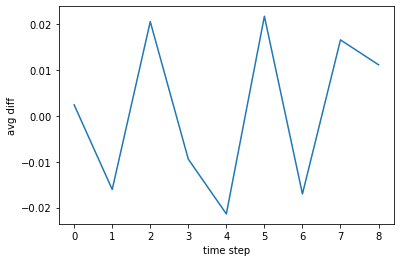

In [10]:
print(len(results))
averages = []

for result in results:
    avg = result.mean()
    averages.append(avg)
    print(avg)

import matplotlib.pyplot as plt

plt.plot(range(len(averages)), averages)
plt.xlabel("time step")
plt.ylabel("avg")
plt.show()